In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
import re
sys.path.append('./modified_medsam_repo')

In [2]:
def read_tag_from_wandb(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        #print(dicto)
        if ('val_dice_score' not in dicto.keys() and 'val_dice_scores/class_Unknown' not in dicto.keys()) or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    desire_cols = ['label', 'val_dice_score']
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    if 'val_dice_score' in runs_df['summary'][0]:
        runs_df['val_dice_score'] = [x['val_dice_score'] for x in runs_df['summary']]
    elif 'val_dice_scores/class_Unknown' in runs_df['summary'][0]:
        runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    if 'num_training_samples' in runs_df['summary'][0]:
        runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
        runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
        desire_cols.append('num_samples_per_epoch')
    
    runs_df['runtime'] = [x['_runtime'] for x in runs_df['summary']]
    desire_cols.append('runtime')

    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[desire_cols]

    #assert ret_df.shape[0] == 102
    assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

In [3]:
def get_histories(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    store_dict = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True

        label_number = int(re.search(r'\d+', name).group())
        store_dict[label_number] = run.history()

    return store_dict

In [5]:
dfo = read_tag_from_wandb('unet_final_main_run', 'singletask_unet', min_epoch_cutoff = 9)
dfo['model_type'] = 'UNet'

dfo2 = read_tag_from_wandb('medsam_constant_final', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
dfo2 = dfo2[['label', 'val_dice_score', 'runtime']]
dfo2['model_type'] = 'MedSAM'

dfo3 = read_tag_from_wandb('medsam_yolo_final', 'singletask_medsam_with_yolo', min_epoch_cutoff = 9)
dfo3 = dfo3[['label', 'val_dice_score', 'runtime']]
dfo3['model_type'] = 'MedSAM + YOLO'

dfo4 = read_tag_from_wandb('medsam_oracle_final', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
dfo4 = dfo4[['label', 'val_dice_score', 'runtime']]
dfo4['model_type'] = 'MedSAM + Oracle'

combined_df = pd.concat([dfo, dfo2, dfo3, dfo4], axis=0, ignore_index=True)
combined_df = combined_df.sort_values(['model_type', 'label']).reset_index(drop=True)

combined_df.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_training_runtimes_12-30-24/training_runtimes.csv', index=False)

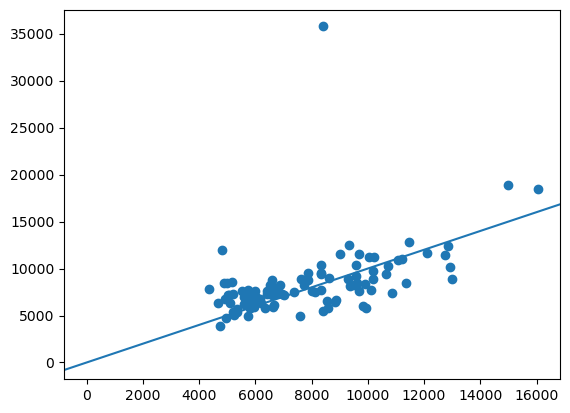

In [6]:
fig, axs = plt.subplots()
axs.scatter(dfo2['runtime'], dfo['runtime'])
axs.axline((0, 0), slope=1)

In [4]:
def process(x, dice_score_name):
    x = x[['_runtime',dice_score_name]].dropna().reset_index(drop=True)
    x['epoch'] = range(0, x.shape[0])
    x = x.rename(columns={dice_score_name: 'val_dice_score'})
    return x

hist_oracle = get_histories('medsam_oracle_final', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
hist_constant = get_histories('medsam_constant_final', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
hist_yolo = get_histories('medsam_yolo_final', 'singletask_medsam_with_yolo', min_epoch_cutoff = 9)
hist_unet = get_histories('unet_final_main_run', 'singletask_unet', min_epoch_cutoff = 9)


for x in hist_oracle.keys():
    hist_oracle[x] = process(hist_oracle[x], 'val_dice_scores/class_Unknown')
for x in hist_constant.keys():
    hist_constant[x] = process(hist_constant[x], 'val_dice_scores/class_Unknown')
for x in hist_yolo.keys():
    hist_yolo[x] = process(hist_yolo[x], 'val_dice_scores/class_Unknown')
for x in hist_unet.keys():
    hist_unet[x] = process(hist_unet[x], 'val_dice_score')

In [14]:
sns.set_style("whitegrid")
palette = sns.color_palette("Dark2")
# set color scheme
my_colors = {'MedSAM': palette[0], 'MedSAM + YOLO': palette[1], 'UNet': palette[2], 'MedSAM + Oracle': palette[3]}

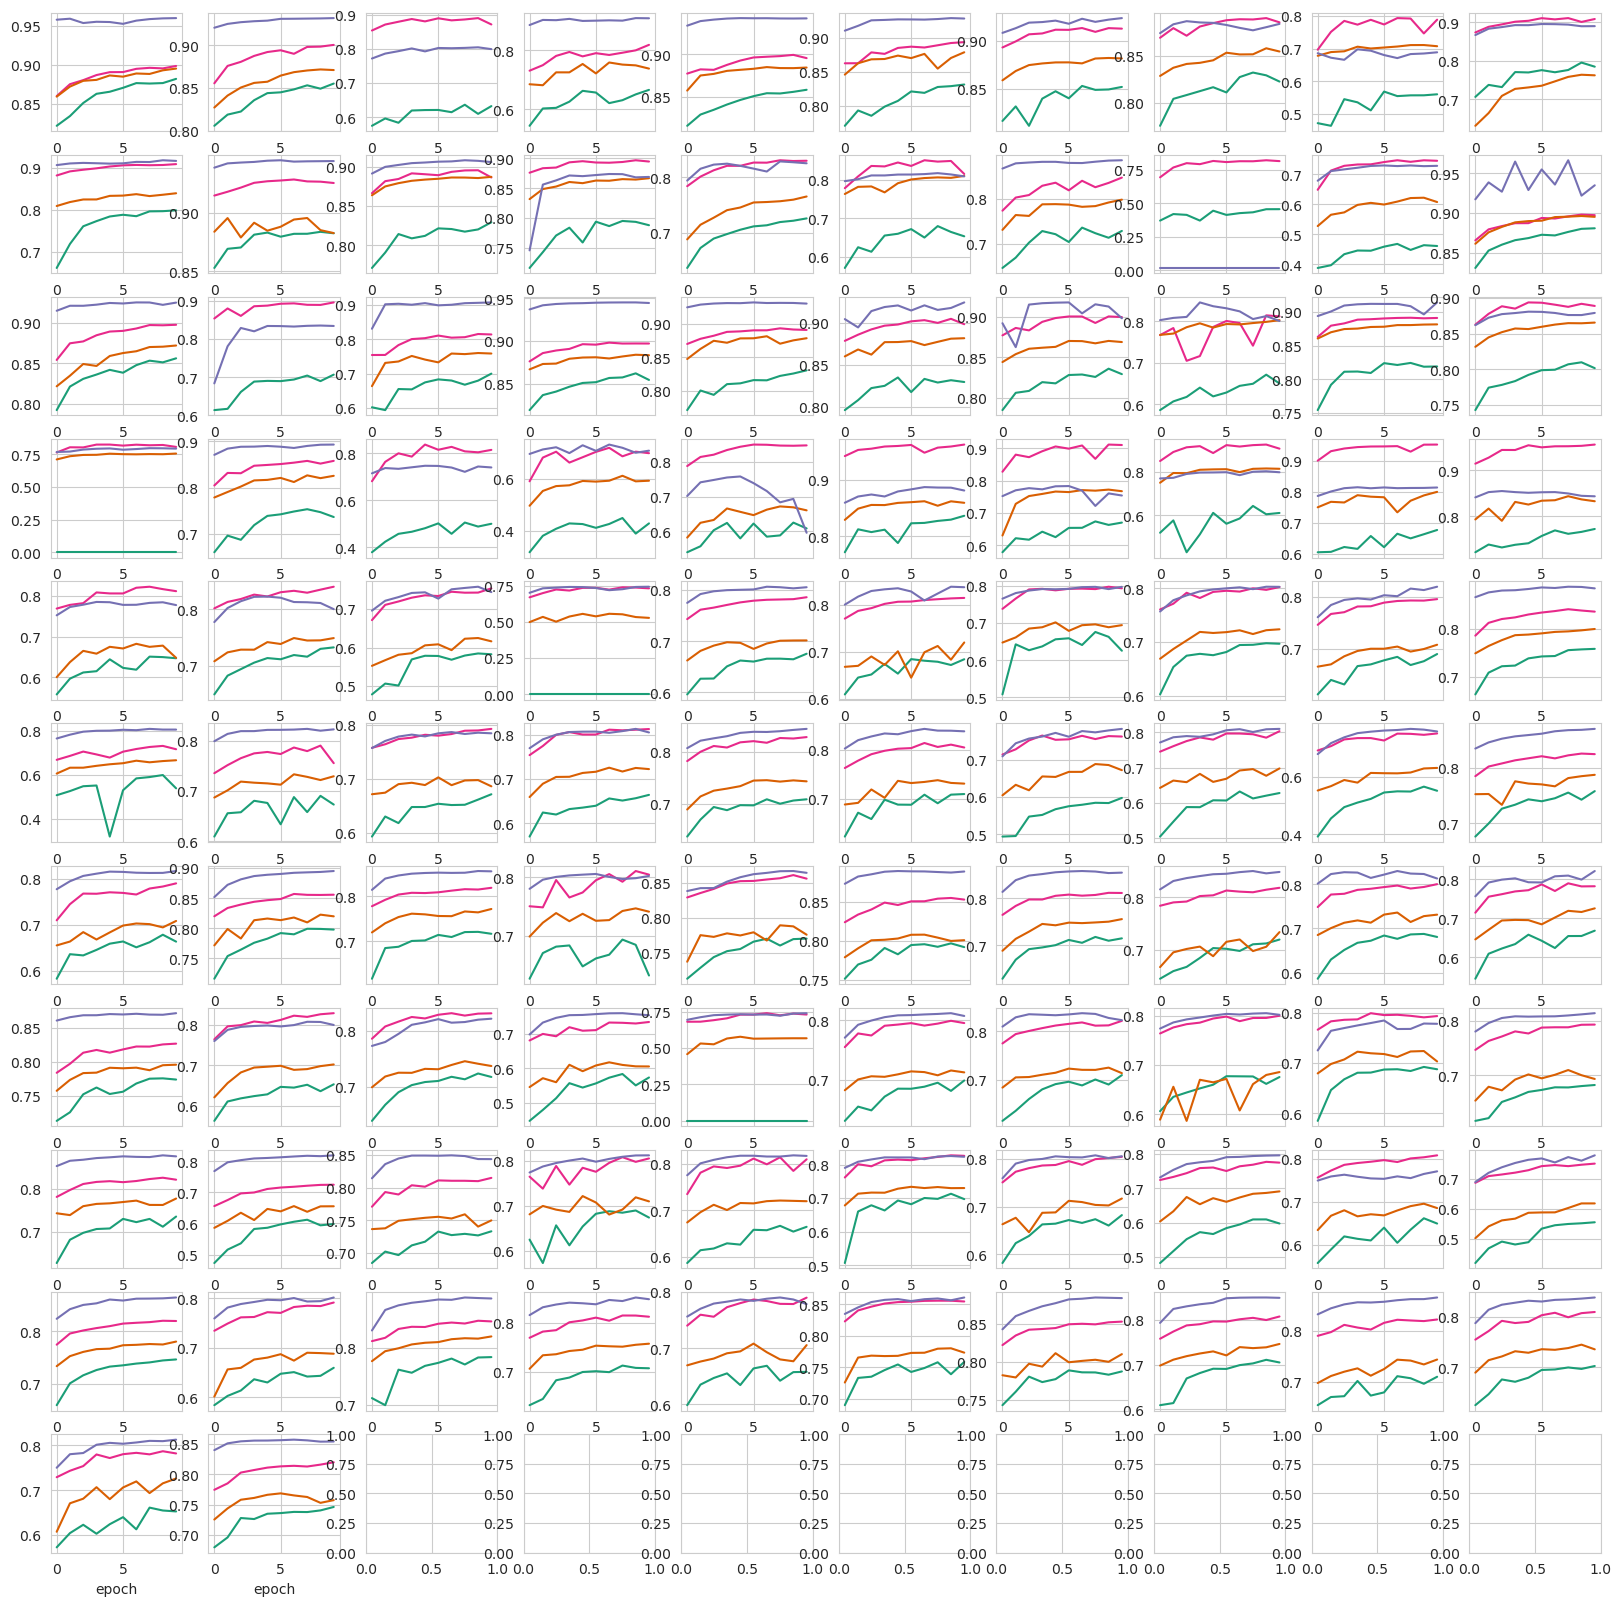

In [15]:
fig, axs = plt.subplots(11, 10, figsize=(20, 20))

for label in range(1, 103):
    # create a dataframe in the long format that contains the dice scores for each model for each epoch
    # then use seaborn to plot a lineplot for each label, with all labels on different subplots

    df_oracle = pd.DataFrame(hist_oracle[label])
    df_oracle['model_type'] = 'MedSAM + Oracle'

    df_constant = pd.DataFrame(hist_constant[label])
    df_constant['model_type'] = 'MedSAM'

    if label in hist_yolo:
        df_yolo = pd.DataFrame(hist_yolo[label])
        df_yolo['model_type'] = 'MedSAM + YOLO'
    else:
        df_yolo = pd.DataFrame()

    df_unet = pd.DataFrame(hist_unet[label])
    df_unet['model_type'] = 'UNet'

    combined_df = pd.concat([df_oracle, df_constant, df_yolo, df_unet], axis=0, ignore_index=True)
    combined_df['label'] = label
    combined_df = combined_df.sort_values(['model_type', 'epoch']).reset_index(drop=True)

    r = (label-1)//10
    c = (label-1)%10
    sns.lineplot(data=combined_df, x='epoch', y='val_dice_score', hue='model_type', ax=axs[r,c], legend=None, palette=my_colors)
    axs[r,c].set_ylabel('')

    
    

Text(0.5, 0, 'Model Type')

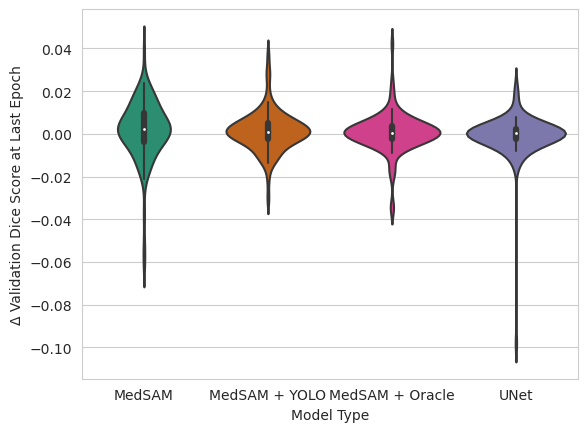

In [32]:
delta_dict = {'MedSAM + Oracle':[], 'MedSAM': [], 'MedSAM + YOLO': [], 'UNet': []}
for label in range(1, 103):

    delta_dict['MedSAM + Oracle'].append(hist_oracle[label].loc[9, 'val_dice_score'] - hist_oracle[label].loc[8, 'val_dice_score'])
    delta_dict['MedSAM'].append(hist_constant[label].loc[9, 'val_dice_score'] - hist_constant[label].loc[8, 'val_dice_score'])
    if label in hist_yolo:
        delta_dict['MedSAM + YOLO'].append(hist_yolo[label].loc[9, 'val_dice_score'] - hist_yolo[label].loc[8, 'val_dice_score'])
    else:
        delta_dict['MedSAM + YOLO'].append(np.nan)
    delta_dict['UNet'].append(hist_unet[label].loc[9, 'val_dice_score'] - hist_unet[label].loc[8, 'val_dice_score'])

delta_df = pd.DataFrame(delta_dict)
delta_df['label'] = range(1, 103)
delta_df = delta_df.sort_values('label').reset_index(drop=True)
delta_df
    
# convert delta_df to long form
delta_df_long = pd.melt(delta_df, id_vars=['label'], var_name='model_type', value_name='delta_dice_score')

# violin plot
fig, axs = plt.subplots()
sns.violinplot(data=delta_df_long, x='model_type', y='delta_dice_score', ax=axs, palette=my_colors, order=['MedSAM', 'MedSAM + YOLO', 'MedSAM + Oracle', 'UNet'])
axs.set_ylabel('Δ Validation Dice Score at Last Epoch')
axs.set_xlabel('Model Type')